In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

2022-02-16 13:05:42.420244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:05:42.425998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:05:42.426734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import os
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2#, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# ResNet50V2 input shape
IMAGE_SIZE = [224, 224]
IMAGE_SHAPE = tuple(IMAGE_SIZE) + (3, )

# 9129MiB
epochs = 50
batch_size = 64

# Image Augmentation
rotation=20
width_shift=0.1
height_shift=0.1
shear=0.1
zoom=0.2

In [4]:
print(IMAGE_SHAPE)

(224, 224, 3)


In [5]:
train_path = 'data/train'

In [6]:
paths = []
data_type = []
labels = []
for dirname, _, filenames in os.walk('data/train'):
    for filename in filenames:
        if '.jpeg' in filename:
            path = dirname + '/' + filename
            paths.append(path)
            labels.append(os.path.split(dirname)[-1])

print(len(paths), len(labels))
data_df = pd.DataFrame({'path': paths, 'label': labels})
train_df, valid_df = train_test_split(data_df, stratify=data_df['label'], test_size=0.2, random_state=0)

7533 7533


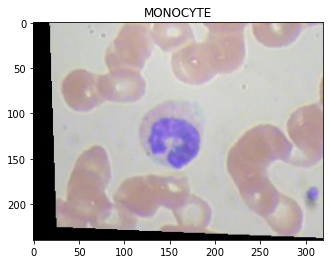

In [7]:
random_image = train_df.sample(1)
plt.title(random_image['label'].iloc[0])
plt.imshow(image.load_img(random_image['path'].iloc[0]))
plt.show()

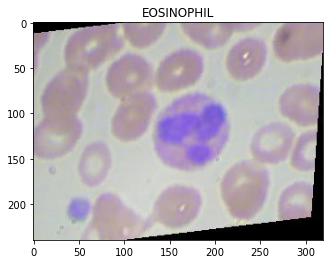

In [8]:
random_image = valid_df.sample(1)
plt.title(random_image['label'].iloc[0])
plt.imshow(image.load_img(random_image['path'].iloc[0]))
plt.show()

#### NEUTROPHIL sample 수가 너무 적어서 class weight를 적용하기 위해서 weight를 계산한다.
https://hyeonchan523.github.io/ds/class-imbalance/

In [9]:
labels_values = train_df['label'].value_counts()
print(labels_values)

labels_count = len(labels_values)

class_weight = (1/labels_values) * (len(train_df)/len(labels_values))
train_df['weight'] = train_df['label'].map(class_weight.to_dict())

EOSINOPHIL    1998
LYMPHOCYTE    1986
MONOCYTE      1982
NEUTROPHIL      60
Name: label, dtype: int64


In [10]:
train_image_gen = ImageDataGenerator(rotation_range=rotation, height_shift_range=height_shift,
                          width_shift_range=width_shift, shear_range=shear, 
                          zoom_range=zoom, horizontal_flip=True, vertical_flip=True,
                          preprocessing_function=preprocess_input)

val_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_data_gen = train_image_gen.flow_from_dataframe(dataframe=train_df,
                            target_size=IMAGE_SIZE,
                            shuffle=True,
                            batch_size=batch_size,
                            class_mode='sparse',
                            x_col='path', y_col='label')

val_data_gen = val_image_gen.flow_from_dataframe(dataframe=valid_df,
                            target_size=IMAGE_SIZE,
                            shuffle=True,
                            batch_size=batch_size,
                            class_mode='sparse',
                            x_col='path', y_col='label')

Found 6026 validated image filenames belonging to 4 classes.
Found 1507 validated image filenames belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -2.117904 max: 2.5896869


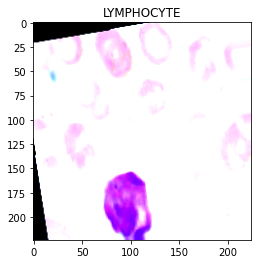

In [12]:
for x, y in train_data_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [13]:
tr_class_weight = class_weight.rename(train_data_gen.class_indices)
tr_class_weight

0     0.754004
1     0.758560
2     0.760091
3    25.108333
Name: label, dtype: float64

In [14]:
print(labels_count)

4


In [15]:
# resNet = ResNet50V2(include_top=True, weights=None, classes=labels_count)
resNet = ResNet50V2(include_top=False, weights=None, input_shape=IMAGE_SHAPE, pooling='avg')
fclayer = Dense(units=labels_count, activation='softmax')(resNet.output)
model = Model(inputs=resNet.input, outputs=fclayer)

2022-02-16 13:05:46.303100: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 13:05:46.305446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:05:46.306218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:05:46.306940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

### overfitting을 방지하고 smooth하게 수렴하도록 lr scheduler를 CosineDecay을 사용한다.
https://velog.io/@changdaeoh/learningrateschedule

In [16]:
# Reference the below code
# def decayed_learning_rate(step):
#   step = min(step, decay_steps)
#   cosine_decay = 0.5 * (1 + cos(pi * step / decay_steps))
#   decayed = (1 - alpha) * cosine_decay + alpha
#   return initial_learning_rate * decayed
init_lr = 0.001
decay_steps = 40
alpha = 0.01
lr_decayed_fn = tf.keras.experimental.CosineDecay(init_lr, decay_steps, alpha=alpha)

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=lr_decayed_fn),
        metrics=['accuracy'])

cp_path = './cp.resnet50v2.ckpt'
result = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=epochs,
  steps_per_epoch=len(train_df) // batch_size,
  validation_steps=len(valid_df) // batch_size,
  class_weight=tr_class_weight.to_dict(),
  callbacks=[
    tf.keras.callbacks.ModelCheckpoint(
      filepath=cp_path,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True),
  ]
)

Epoch 1/50


2022-02-16 13:06:01.333346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-02-16 13:06:01.720583: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-16 13:06:01.720906: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-16 13:06:01.720918: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-02-16 13:06:01.721261: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-16 13:06:01.721298: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


94/94 [==============================] - 47s 447ms/step - loss: 1.5148 - accuracy: 0.3287 - val_loss: 1.3769 - val_accuracy: 0.3315
Epoch 2/50
94/94 [==============================] - 46s 482ms/step - loss: 1.3500 - accuracy: 0.4148 - val_loss: 1.3748 - val_accuracy: 0.3281
Epoch 3/50
94/94 [==============================] - 47s 492ms/step - loss: 1.3211 - accuracy: 0.4284 - val_loss: 1.3204 - val_accuracy: 0.3940
Epoch 4/50
94/94 [==============================] - 49s 521ms/step - loss: 1.2562 - accuracy: 0.4931 - val_loss: 1.1997 - val_accuracy: 0.5122
Epoch 5/50
94/94 [==============================] - 47s 495ms/step - loss: 1.1572 - accuracy: 0.5758 - val_loss: 1.0546 - val_accuracy: 0.5856
Epoch 6/50
94/94 [==============================] - 48s 509ms/step - loss: 1.0551 - accuracy: 0.6050 - val_loss: 0.9211 - val_accuracy: 0.6603
Epoch 7/50
94/94 [==============================] - 49s 513ms/step - loss: 0.9582 - accuracy: 0.6575 - val_loss: 0.8434 - val_accuracy: 0.6678
Epoch 8/50

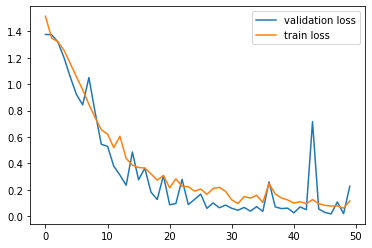

In [18]:
plt.plot(result.history['val_loss'], label='validation loss')
plt.plot(result.history['loss'], label='train loss')
plt.legend()
plt.show()

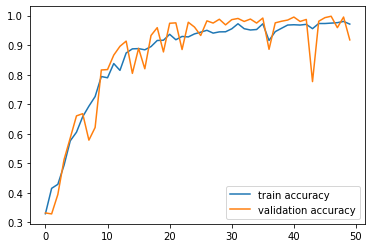

In [19]:
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [22]:
class_names = dict(zip(train_data_gen.class_indices.values(), train_data_gen.class_indices.keys()))
test_file_name = []
predicted_class = []
for dirname, _, filenames in os.walk('data/test/all'):
    for filename in filenames:
        if '.jpeg' in filename:
            path = dirname + '/' + filename
            test_file_name.append(filename)
            img = load_img(path, target_size=IMAGE_SIZE)
            img = preprocess_input(image.img_to_array(img))
            img = img.reshape((1,) + img.shape)
            predicted_class.append(class_names[np.argmax(model.predict(img))])

In [23]:
pd.DataFrame({'Filename': test_file_name, 'Prediction': predicted_class}).sort_values(by=['Filename']).to_csv('./team2.resnet50v2.nor.csv', index=False)